# Public Models Assessment

---

## Imports

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from transformers import logging
from transformers import pipeline
from tqdm import tqdm

In [2]:
logging.set_verbosity_error()

In [3]:
MAX_SEQUENCE_LENGTH = 200

---

## Functions 

In [26]:
def run_classification(model):
    global test_pv
    
    return [model(text) for text in tqdm(test_pv.reset_index().text.tolist())]

In [27]:
def create_predictions(labels, label_type="numbered", threshold=0.2):
    global target_names, test_pv, ge_labels
    
    pred = np.zeros((len(labels), len(target_names)))
    for i, label_list in enumerate(labels):
        for label in label_list[0]:
            if label["score"] > 0.2:
                if label_type == "numbered":
                    pred[i, int(label["label"].replace("LABEL_", ""))] = 1
                else:
                    pred[i, ge_labels.index(label["label"])] = 1
    
    return pred

In [44]:
def show_metrics(predictions):
    global dataset, test_pv, ge_labels
    
    print("-" * 125)
    print(
        "Macro F1:", f1_score(test_pv[ge_labels].values, predictions, average="macro"),
        "\nMicro F1:", f1_score(test_pv[ge_labels].values, predictions, average="micro"),
    )
    print()
    
    print("-" * 125)
    print(classification_report(test_pv[ge_labels].values, predictions, target_names=ge_labels))
    print()
    
    cm = confusion_matrix(np.argmax(test_pv[ge_labels].values, axis=1), np.argmax(predictions, axis=1))
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(20,7))
    sns.heatmap(
        pd.DataFrame(cm, columns=target_names, index=target_names),
        annot=True,
        fmt="1.2f"
    )
    plt.show()
    
    print("-" * 125)
    print("Misclassification Token size")
    test = dataset.loc[lambda f: f["set"] == "test"]
    pred = pd.DataFrame(predictions, columns=ge_labels)
    pred["code"] = test_pv.reset_index()["code"].values
    pred = pred.melt(id_vars=["code"], var_name="goemotion", value_name="flag")
    pred = pred.loc[lambda f: f["flag"] == 1]
    test = test.merge(pred, on=["code", "goemotion"], how="left")
    
    test["token_len"] = test["text"].str.split().apply(len)
    
    corrclass = test[test["flag"].notnull()]
    misclass = test[test["flag"].isnull()]
    
    print("Tokens for correct classification:", corrclass["token_len"].mean())
    print("Tokens for incorrect classification:", misclass["token_len"].mean())
    print()
    
    print("-" * 125)
    print("Examples misclassification:")
    for label in ge_labels:
        example = misclass[misclass["goemotion"] == label]
        print(label)
        
        if example.shape[0] == 0:
            continue
        elif example.shape[0] < 3:
            example = example.sample(example.shape[0])
        else:
            example = example.sample(3)
        
        for text in example.text.tolist():
            print("=" * 100)
            print(text)
            print("=" * 100)
        print()

---

## Data Loading

In [4]:
dataset = pd.read_parquet("../data/clean_data.parquet")

In [5]:
ge_labels = []
with open("../data/emotions.txt", "r", encoding="utf-8") as f:
    for line in f:
        ge_labels.append(line.rstrip())

In [6]:
target_names = sorted(list(dataset["goemotion"].unique()))
test_pv = (
    dataset.loc[lambda f: f["set"] == "test"]
    .pivot_table(index=["code", "text"], columns="goemotion", values="set", aggfunc="count", fill_value=0)
)

---

## Models 

### BERT Finetuned 

https://huggingface.co/justin871030/bert-base-uncased-goemotions-group-finetuned

https://github.com/justin871030/GoEmotions/tree/main

- Macro F1: 0.532031

### DistilBERT Finetuned 

https://huggingface.co/jungealexander/distilbert-base-uncased-finetuned-go_emotions_20220608_1

- Loss: 0.0857
- F1: 0.5575
- Roc Auc: 0.7242
- Accuracy: 0.4364

In [7]:
dbt = pipeline(
    'sentiment-analysis', 
    model="jungealexander/distilbert-base-uncased-finetuned-go_emotions_20220608_1", 
    return_all_scores=True
)

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Using C:\Users\pedro.forli\AppData\Local\torch_extensions\torch_extensions\Cache\py39_cu117 as PyTorch extensions root...
Creating extension directory C:\Users\pedro.forli\AppData\Local\torch_extensions\torch_extensions\Cache\py39_cu117\cuda_kernel...
C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\torch\utils\cpp_extension.py:359: UserWarning: Error checking compiler version for cl: [WinError 2] The system cannot find the file specified
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\pedro.forli\AppData\Local\torch_extensions\torch_extensions\Cache\py39_cu117\cuda_kernel

In [29]:
dbt_labels = run_classification(dbt)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [01:20<00:00, 67.53it/s]


In [31]:
dbt_pred = create_predictions(dbt_labels, label_type="numbered")

-----------------------------------------------------------------------------------------------------------------------------
Macro F1: 0.44244223148216955 
Micro F1: 0.5871635043496131

-----------------------------------------------------------------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.59      0.80      0.68       504
     amusement       0.75      0.91      0.82       264
         anger       0.40      0.56      0.47       198
     annoyance       0.28      0.45      0.35       320
      approval       0.34      0.44      0.38       351
        caring       0.35      0.46      0.40       135
     confusion       0.35      0.58      0.43       153
     curiosity       0.44      0.75      0.56       284
        desire       0.59      0.43      0.50        83
disappointment       0.26      0.25      0.26       151
   disapproval       0.33      0.52      0.40       267
       disgust

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


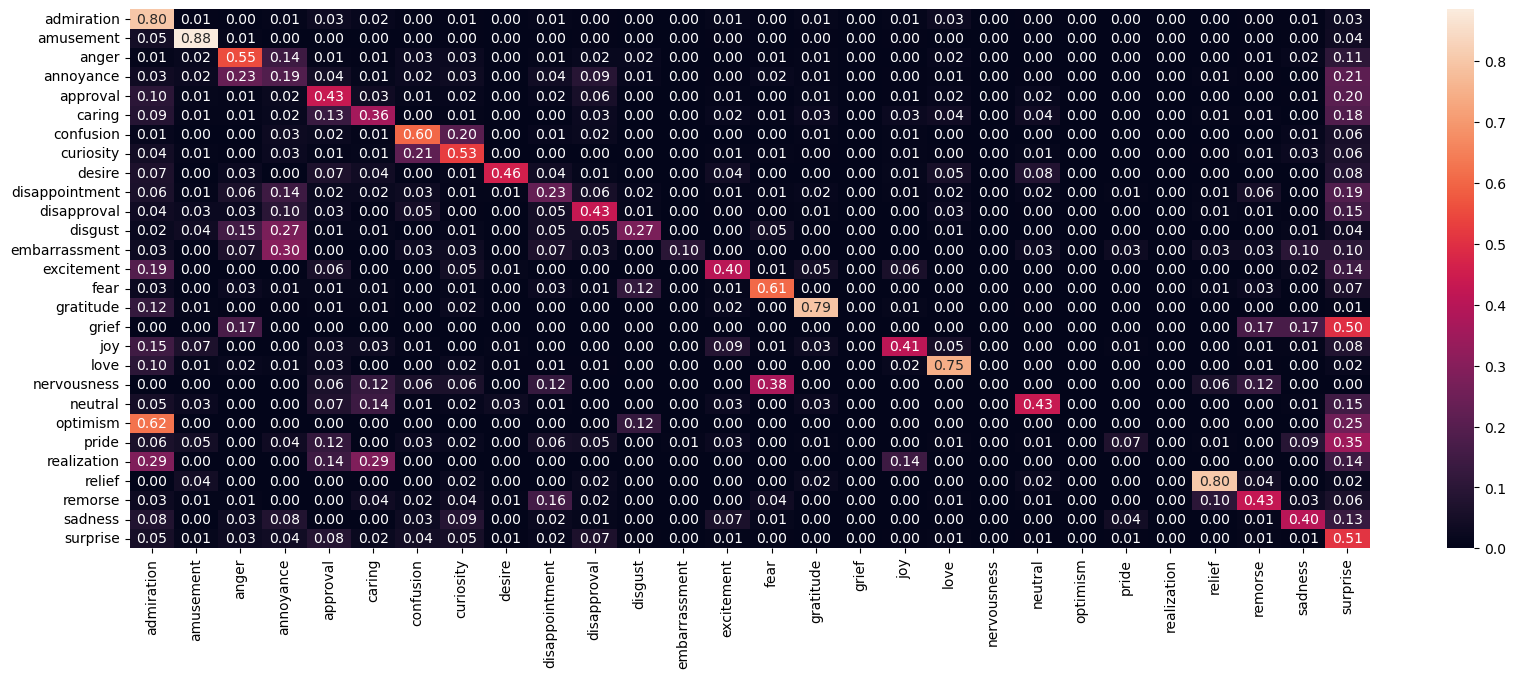

-----------------------------------------------------------------------------------------------------------------------------
Misclassification Token size
Tokens for correct classification: 12.496966868875408
Tokens for incorrect classification: 13.76798825256975

-----------------------------------------------------------------------------------------------------------------------------
Examples misclassification:
admiration
They are new but got over 100 reviews in less than a month so I'm assuming they are just slammed. Thanks for the input
LOVE THIS!!
You have a talent use it, take your time would love some pop kids melodies etc subscribers will come for sure

amusement
Attempt to con the senate. This should continue to be entertaining
Once some joked that I was a [NAME] just because my family had moved to West Germany for a couple years when I was a infant.
Your username makes me think you would appreciate this joke of mine.

anger
Look I'm not saying that I agree with them, theres

In [39]:
show_metrics(dbt_pred)

### Roberta Base 

https://huggingface.co/SamLowe/roberta-base-go_emotions

- Micro F1 0.585
- ROC AUC 0.751
- Accuracy 0.474

In [10]:
roberta = pipeline('sentiment-analysis', model='SamLowe/roberta-base-go_emotions', return_all_scores=True)

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [11]:
roberta_labels = run_classification(roberta)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [02:49<00:00, 31.94it/s]


In [40]:
roberta_pred = create_predictions(roberta_labels, label_type="named")

-----------------------------------------------------------------------------------------------------------------------------
Macro F1: 0.4992045852054491 
Micro F1: 0.5950699533644237

-----------------------------------------------------------------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.63      0.81      0.71       504
     amusement       0.73      0.94      0.82       264
         anger       0.49      0.55      0.52       198
     annoyance       0.28      0.43      0.34       320
      approval       0.34      0.52      0.41       351
        caring       0.35      0.44      0.39       135
     confusion       0.28      0.71      0.40       153
     curiosity       0.45      0.76      0.57       284
        desire       0.47      0.57      0.52        83
disappointment       0.32      0.38      0.34       151
   disapproval       0.34      0.54      0.42       267
       disgust 

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


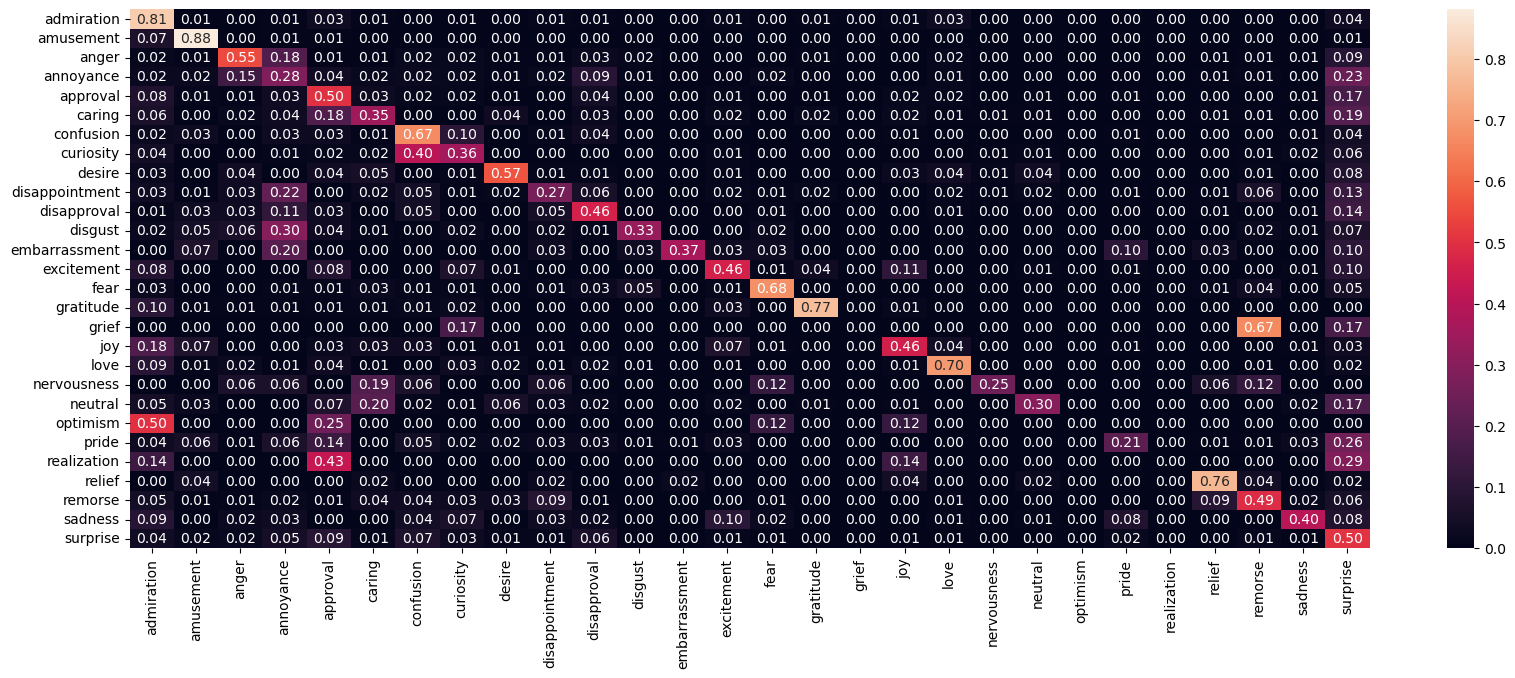

-----------------------------------------------------------------------------------------------------------------------------
Misclassification Token size
Tokens for correct classification: 12.499776085982983
Tokens for incorrect classification: 13.884057971014492

-----------------------------------------------------------------------------------------------------------------------------
Examples misclassification:
admiration
Oh wow. You really know your stuff. Luckily I don't have diabetes yet so that's something
I love that username
Sexy teeth.

amusement
The way him and his mom talk to each other is like a little boy and his Mommy!
RIGHT?! My mom would literally never forgive the bitch 😂
oh the irony

anger
I beat my dad
BASED AND REDPILLED
Read divorce busting and kill all marriage counselors. As much as it sucks...youve been given a gift by him giving you time.

annoyance
Go play Farmville if you can't keep it up.
The people that use the image and leave that braindead comment are

In [41]:
show_metrics(roberta_pred)

### Roberta Large 

https://huggingface.co/IsaacZhy/roberta-large-goemotions

- Loss: 0.0568
- F1: 0.5868
- Roc Auc: 0.7616
- Accuracy: 0.4821

In [13]:
roberta_large = pipeline('sentiment-analysis', model='IsaacZhy/roberta-large-goemotions', return_all_scores=True)

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [14]:
robertal_labels = run_classification(roberta_large)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [09:10<00:00,  9.86it/s]


In [42]:
robertal_pred = create_predictions(robertal_labels, label_type="named")

-----------------------------------------------------------------------------------------------------------------------------
Macro F1: 0.5343813883997255 
Micro F1: 0.5910508474576271

-----------------------------------------------------------------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.58      0.81      0.68       504
     amusement       0.71      0.95      0.81       264
         anger       0.47      0.61      0.53       198
     annoyance       0.29      0.53      0.38       320
      approval       0.36      0.41      0.39       351
        caring       0.37      0.50      0.43       135
     confusion       0.31      0.59      0.41       153
     curiosity       0.43      0.79      0.55       284
        desire       0.57      0.57      0.57        83
disappointment       0.36      0.28      0.32       151
   disapproval       0.36      0.53      0.43       267
       disgust 

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


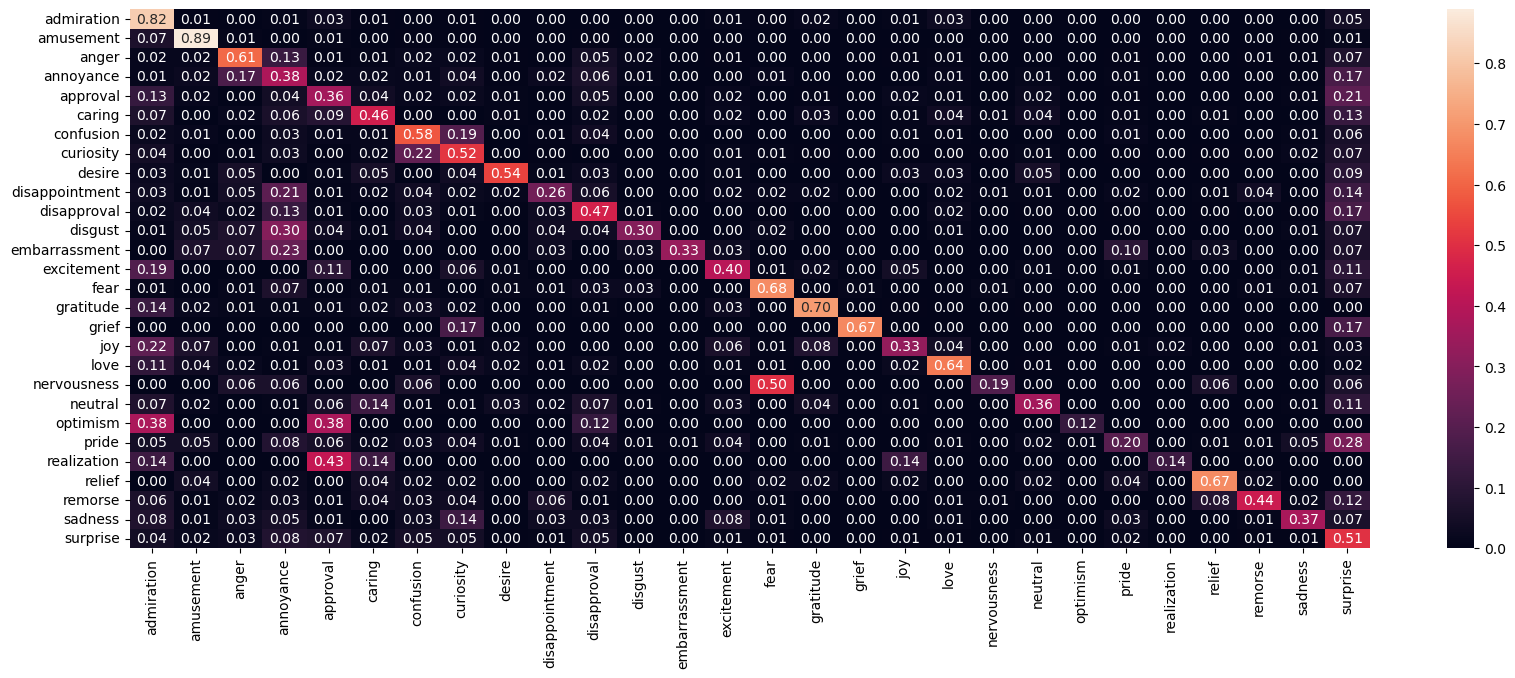

-----------------------------------------------------------------------------------------------------------------------------
Misclassification Token size
Tokens for correct classification: 12.550126175728378
Tokens for incorrect classification: 13.69746192893401

-----------------------------------------------------------------------------------------------------------------------------
Examples misclassification:
admiration
But you appear to think you have some amazing insights on how to handle a pwBPD. Have you considered the possibility that you don't?
I had the biggest smile!
This sub doesn’t like the pro sports teams until they win a championship. Then everyone becomes a die hard fan.

amusement
Because it’s more fun?
I had to watch x3 to make sure I didn't miss something 😂
oh the irony

anger
I would hate to see another [NAME] situation where [NAME] gets hurt again because he wasn't fully recovered.
Except forming an opinion of a topic without even having basic knowledge of said

In [45]:
show_metrics(robertal_pred)

### Roberta BNE 

https://huggingface.co/mrm8488/roberta-large-bne-finetuned-go_emotions-es

- Loss: 3.2457
- Accuracy: 0.5668
- F1: 0.5572

In [16]:
roberta_bne = pipeline(
    'sentiment-analysis', 
    model='mrm8488/roberta-large-bne-finetuned-go_emotions-es', 
    return_all_scores=True
)

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [17]:
roberta_bne_labels = run_classification(roberta_bne)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [10:15<00:00,  8.82it/s]


In [50]:
roberta_bne_pred = create_predictions(roberta_bne_labels, label_type="numbered")

-----------------------------------------------------------------------------------------------------------------------------
Macro F1: 0.08742868052796397 
Micro F1: 0.3482438701126574

-----------------------------------------------------------------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.56      0.01      0.02       504
     amusement       0.82      0.44      0.57       264
         anger       0.29      0.02      0.04       198
     annoyance       0.00      0.00      0.00       320
      approval       0.67      0.01      0.01       351
        caring       0.00      0.00      0.00       135
     confusion       0.00      0.00      0.00       153
     curiosity       0.50      0.25      0.33       284
        desire       0.00      0.00      0.00        83
disappointment       0.00      0.00      0.00       151
   disapproval       0.25      0.00      0.01       267
       disgust

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


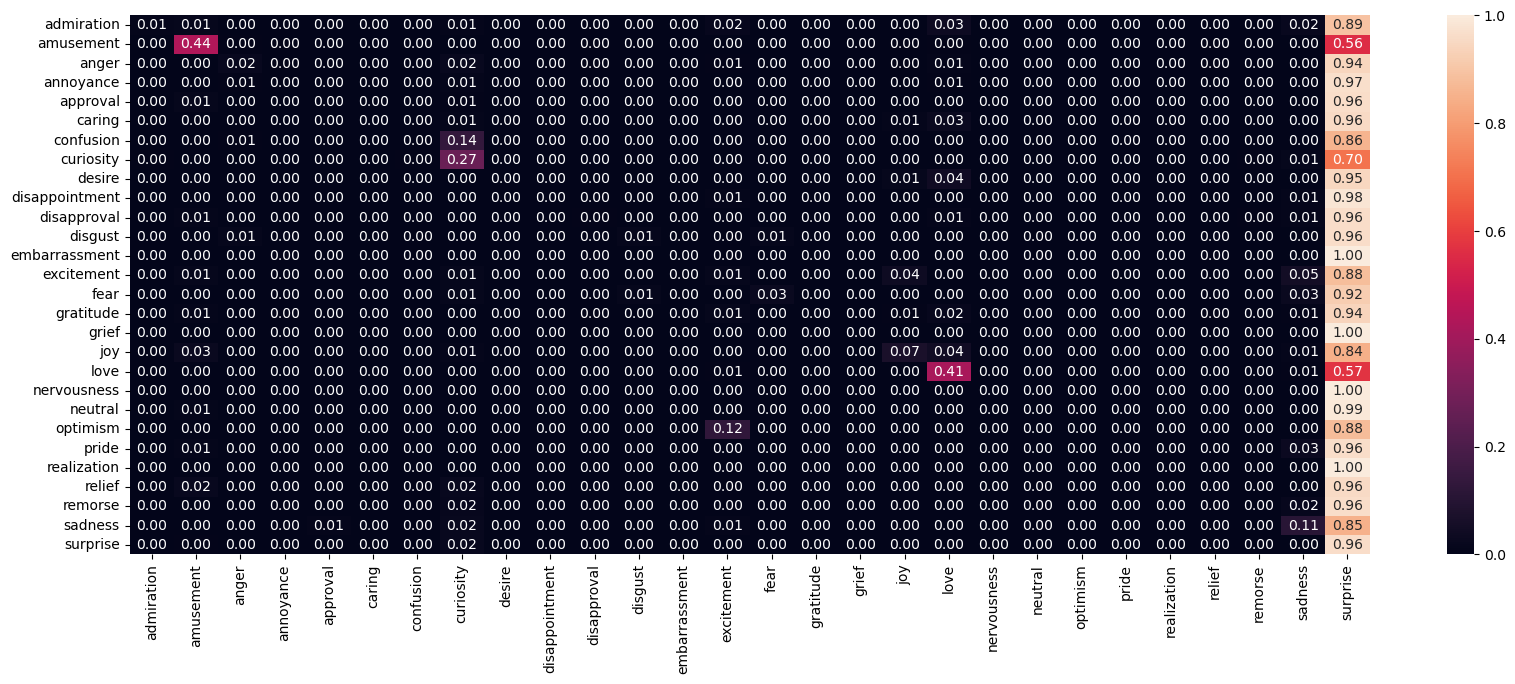

-----------------------------------------------------------------------------------------------------------------------------
Misclassification Token size
Tokens for correct classification: 11.947193149381542
Tokens for incorrect classification: 13.384669978708304

-----------------------------------------------------------------------------------------------------------------------------
Examples misclassification:
admiration
How generous :) you must really make them happy. Good on you for that
Ah!! Was not expecting to read that this morning on my commute 😭 lol Just so beautiful! 
That poster is amazing. He needs to sell these online!

amusement
Because they are triggered. I’m just stating my opinion. It’s a bit fun.
Left or right, doesn't matter, just laugh at statists on all sides 
The original is funnier... or at least it's funny, to begin with.

anger
Baby rape. Can’t make a funny joke about it.
You really don't comprehend anything my man, now do you? Goodness gracious the amount

In [51]:
show_metrics(roberta_bne_pred)

### EmoRoBERTa 

https://huggingface.co/arpanghoshal/EmoRoBERTa

- Macro F1 - 0.493

In [19]:
emoroberta = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa', return_all_scores=True)

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pedro.forli\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [20]:
emoroberta_labels = run_classification(emoroberta)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [43:11<00:00,  2.09it/s]


In [52]:
emoroberta_pred = create_predictions(emoroberta_labels, label_type="named")

-----------------------------------------------------------------------------------------------------------------------------
Macro F1: 0.4456055282135877 
Micro F1: 0.5162217348559329

-----------------------------------------------------------------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.66      0.63      0.64       504
     amusement       0.68      0.87      0.76       264
         anger       0.43      0.52      0.47       198
     annoyance       0.32      0.28      0.30       320
      approval       0.31      0.41      0.35       351
        caring       0.35      0.51      0.42       135
     confusion       0.36      0.44      0.40       153
     curiosity       0.46      0.58      0.51       284
        desire       0.53      0.34      0.41        83
disappointment       0.25      0.19      0.21       151
   disapproval       0.34      0.39      0.36       267
       disgust 

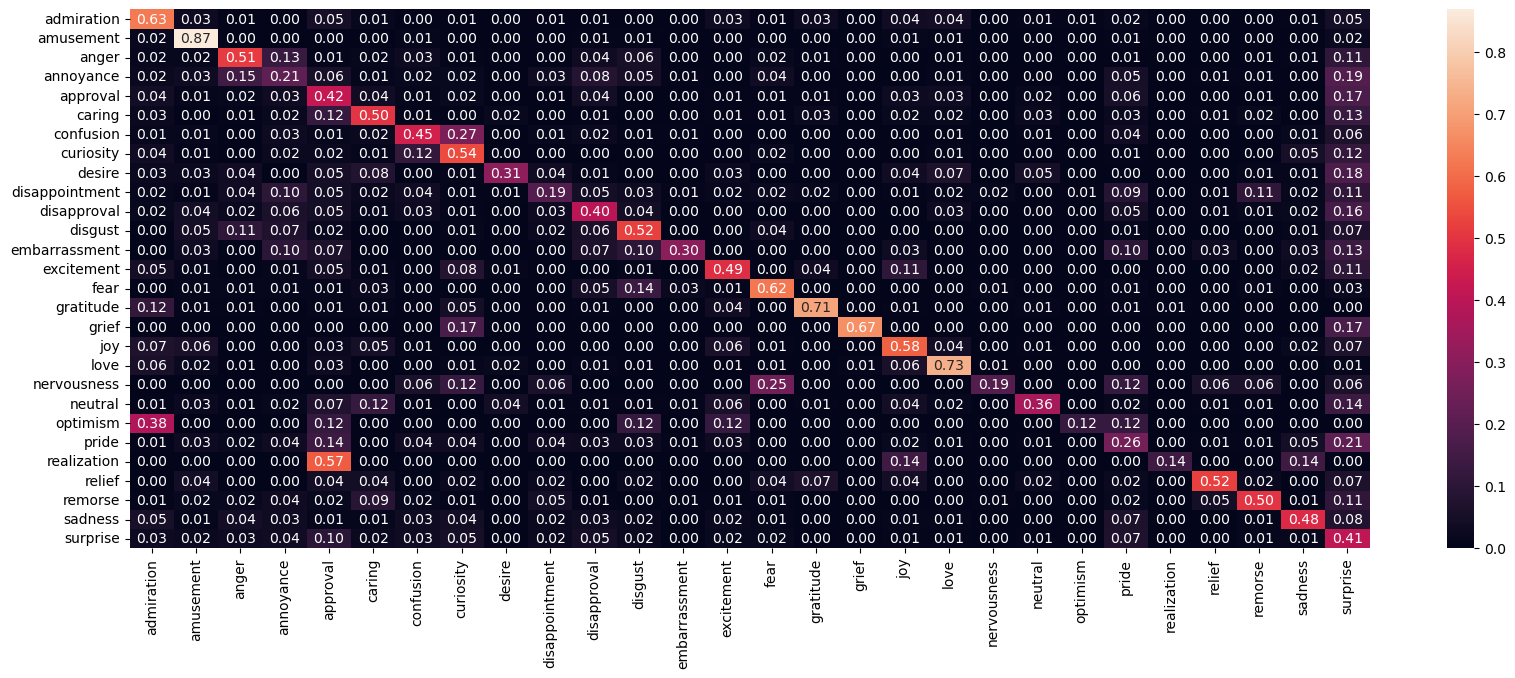

-----------------------------------------------------------------------------------------------------------------------------
Misclassification Token size
Tokens for correct classification: 12.293876355112804
Tokens for incorrect classification: 13.62517146776406

-----------------------------------------------------------------------------------------------------------------------------
Examples misclassification:
admiration
You’re not a loser. You’re a whole and complete person unto yourself.
Almost in tears watching him celebrate, true captain ❤️
Wow that’s like - sound porn.

amusement
Got me spitted coffee all over my phone🤣
I had to watch x3 to make sure I didn't miss something 😂
There’s always that one friend 😂

anger
You're an idiot and no one believes you and your telegram jerk-off buddies.
NEVER RUNNING FROM A REAL FIGHT!
Yeah, he does. Just because he draws different conclusions than you doesn't mean he isn't reading [NAME]. Get out of your little bubble.

annoyance
Y’all ar

In [53]:
show_metrics(emoroberta_pred)

### EmoGPT 

https://huggingface.co/tingtone/go_emo_gpt

- Loss: 0.0964
- F1: 0.6010
- Roc Auc: 0.7659
- Accuracy: 0.4996

In [22]:
emogpt = pipeline('sentiment-analysis', model='tingtone/go_emo_gpt', return_all_scores=True)

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [23]:
emogpt_labels = run_classification(emogpt)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [03:11<00:00, 28.28it/s]


In [54]:
emogpt_pred = create_predictions(emogpt_labels, label_type="named")

-----------------------------------------------------------------------------------------------------------------------------
Macro F1: 0.5018997608753327 
Micro F1: 0.6058181818181818

-----------------------------------------------------------------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.63      0.77      0.70       504
     amusement       0.73      0.91      0.81       264
         anger       0.41      0.55      0.47       198
     annoyance       0.37      0.31      0.34       320
      approval       0.46      0.37      0.41       351
        caring       0.33      0.46      0.38       135
     confusion       0.36      0.45      0.40       153
     curiosity       0.51      0.62      0.56       284
        desire       0.58      0.51      0.54        83
disappointment       0.47      0.19      0.27       151
   disapproval       0.40      0.45      0.42       267
       disgust 

C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro.forli\.conda\envs\w266\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


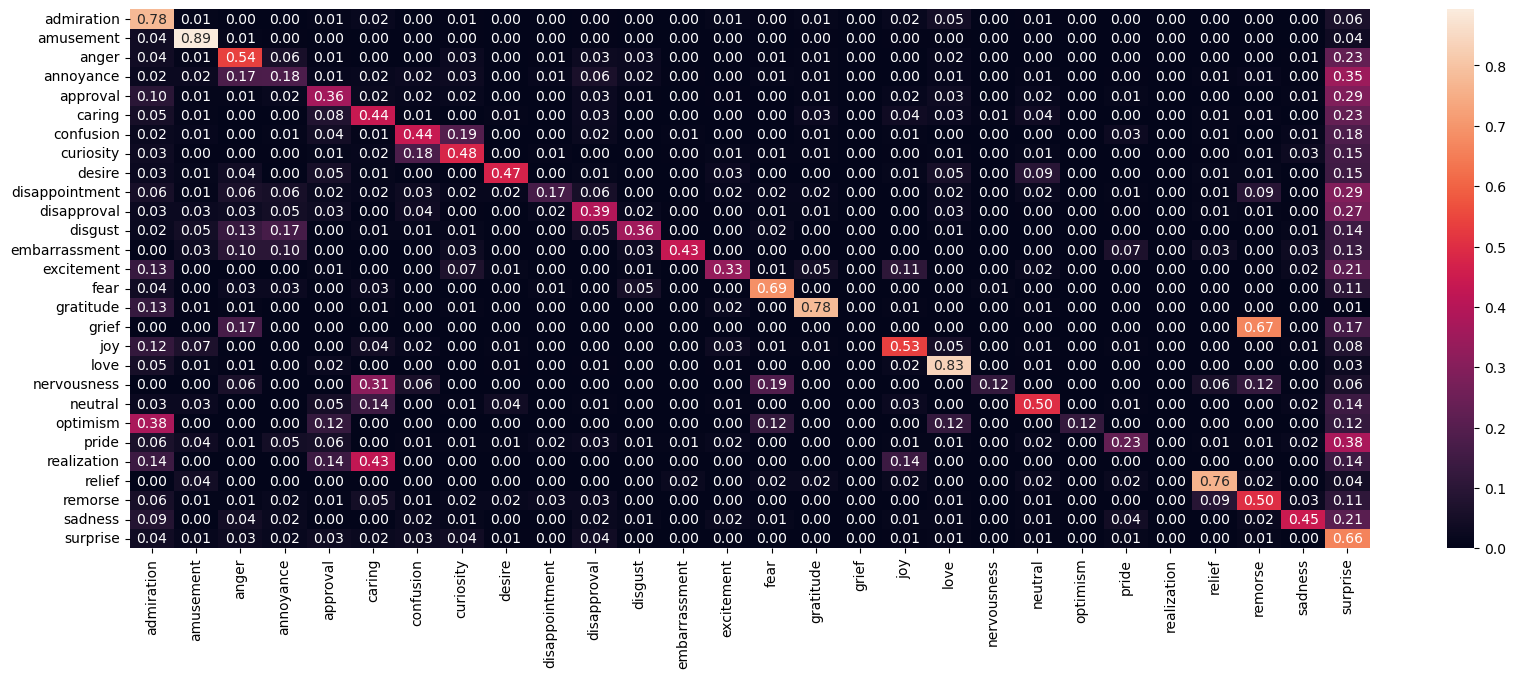

-----------------------------------------------------------------------------------------------------------------------------
Misclassification Token size
Tokens for correct classification: 12.515726290516206
Tokens for incorrect classification: 13.660813308687615

-----------------------------------------------------------------------------------------------------------------------------
Examples misclassification:
admiration
Seriously, I’ve been catching and loving this one since it first came out.
One of my favorite moments
wow, we really live in future

amusement
There’s always that one friend 😂
Left or right, doesn't matter, just laugh at statists on all sides 
[NAME] [NAME] Bros are losing their minds over this tweet.

anger
Toxic feminism is ti blame
Maybe [NAME].
Somebody gettin fired

annoyance
FYI not all skinheads are racists. [NAME] suck and should be confronted.
This really circled my jerk
You now have 3 threads about this within the last 10 hours. Pick one and stick with 

In [55]:
show_metrics(emogpt_pred)

---